In [2]:
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# in_path = './data/ml-1m-raw/'
# rating_file = in_path + 'ratings.dat'

rating_file = '/content/drive/MyDrive/Colab Notebooks/ml-1m-raw/ratings.dat'

In [4]:
raw = []
with open(rating_file, 'r') as f_read:
    for line in f_read.readlines():
        line_list = line.split('::')
        raw.append(line_list)
raw = np.array(raw, dtype=np.int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
plt.rcParams['figure.figsize'] = (15, 4)

In [8]:
raw = np.array(raw, dtype=np.int)
user_freq = np.bincount(raw[:, 0]) # [user1's freq, user2's freq, ..., userN's freq]
user_freq = [i for i in user_freq if i>0] # exclude dummy users
user_freq = np.bincount(user_freq)
user_x_axis = np.array(range(len(user_freq)))
print(f'users` max freq: {len(user_freq)-1}')

users` max freq: 2314


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [10]:
item_freq = np.bincount(raw[:, 1]) # [item1's freq, item2's freq, ..., itemM's freq]
item_freq = [i for i in item_freq if i>0] # exclude dummy items
item_freq = np.bincount(item_freq)
item_x_axis = np.array(range(len(item_freq)))
print(f'items` max freq: {len(item_freq)-1}')

items` max freq: 3428


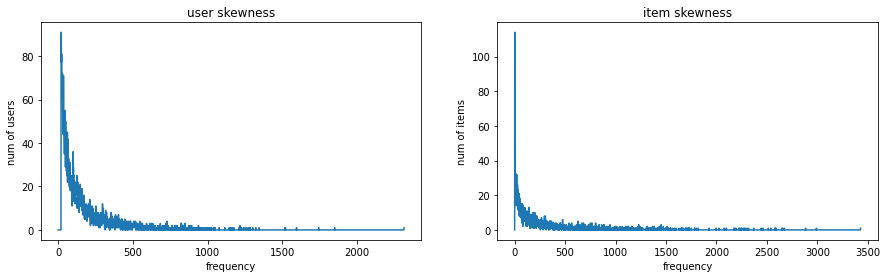

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(user_x_axis, user_freq)
axs[0].set_title('user skewness')
axs[0].set_xlabel('frequency')
axs[0].set_ylabel('num of users')
axs[1].plot(item_x_axis, item_freq)
axs[1].set_title('item skewness')
axs[1].set_xlabel('frequency')
axs[1].set_ylabel('num of items')
plt.show()

In [ ]:
user_ids = list()
item_ids = list()
user_map = dict() # raw -> new
item_map = dict() # raw -> new

user_ids = np.unique(raw[:, 0])
item_ids = np.unique(raw[:, 1])

user_map = {v: i for (i, v) in enumerate(user_ids)}
item_map = {v: i for (i, v) in enumerate(item_ids)}

new = [[user_map[u], item_map[i], r] for (u, i, r)
       in zip(raw[:, 0], raw[:, 1], raw[:, 2])] # new array
new = np.array(new)
print(new.shape)

(1000209, 3)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(new, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
print(train.shape)
print(test.shape)

(800167, 3)
(200042, 3)


In [ ]:
num_users = max(max(train[:, 0]), max(test[:, 0])) + 1
num_items = max(max(test[:, 1]), max(test[:, 1])) + 1

In [ ]:
'''
P: |U| * K (User latent factors)
Q: |I| * K (Item latent factors)
K: latent dimensionality
'''
K = 10
P = np.random.rand(num_users, K)
Q = np.random.rand(num_items, K)
Q = Q.T

In [ ]:
'''
epochs: iterations
alpha: learning rate
beta: regularization parameter
'''
epochs=20
alpha=0.0002
beta=0.02

In [ ]:
from sklearn.metrics import mean_squared_error
import time

In [ ]:
for epoch in range(epochs):
    start_time = time.time()
    # train
    for row in train:
        i, j, r = row[0], row[1], row[2]

        # calculate error
        eij = r - np.dot(P[i, :], Q[:, j])

        for k in range(K):
            # calculate gradient with a and beta parameter
            P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
            Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
    
    # evaluation on training dataset
    train_y = []
    train_y_pred = []
    
    for row in train:
        i, j, r = row[0], row[1], row[2]
        train_y.append(r)
        train_y_pred.append(np.dot(P[i, :], Q[:, j]))

    train_rmse = mean_squared_error(train_y, train_y_pred)**0.5
    
    # evaluation on test dataset
    test_y = []
    test_y_pred = []
    
    for row in test:
        i, j, r = row[0], row[1], row[2]
        test_y.append(r)
        test_y_pred.append(np.dot(P[i, :], Q[:, j]))
    
    test_rmse = mean_squared_error(test_y, test_y_pred)**0.5
    end_time = time.time()
    print(f'[{end_time-start_time:.2f}s] Epoch: {epoch:3d}, ',
          f'TrnRMSE: {train_rmse:.4f}, TestRMSE: {test_rmse:.4f}')

[58.13s] Epoch:   0,  TrnRMSE: 1.2273, TestRMSE: 1.2304
[57.13s] Epoch:   1,  TrnRMSE: 1.1004, TestRMSE: 1.1066
[57.95s] Epoch:   2,  TrnRMSE: 1.0437, TestRMSE: 1.0522
[57.18s] Epoch:   3,  TrnRMSE: 1.0113, TestRMSE: 1.0214
[57.86s] Epoch:   4,  TrnRMSE: 0.9901, TestRMSE: 1.0015


KeyboardInterrupt: ignored